# Intracranial Hemorrhage (ICH) Classification

## Author: Junyuan Zheng

### Date: 06/10/2020

### Part 1: EDA
### Part 2: Training
### Part 3: Visualization

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [51]:
import glob
import os
import cv2

In [52]:
import tensorflow as tf
from tensorflow import keras

# Part 1: Exploratory Data Analysis

## 1.1 Explore the files

In [53]:
# file paths
train_dir = './train_images/'
test_dir = './test_images/'
train_info_path = './labels/behold_coding_challenge_train.csv'
test_info_path = './labels/behold_coding_challenge_test.csv'

In [54]:
# get list of paths of images
train_filenames = glob.glob(train_dir+'*') # Return a list of paths matching a pathname pattern
test_filenames = glob.glob(test_dir+'*')

In [55]:
print ('number of training imgs:', len(train_filenames))
print ('number of test imgs:', len(test_filenames))

number of training imgs: 8542
number of test imgs: 4019


In [56]:
# read in the csv files
train_info = pd.read_csv(train_info_path)
test_info = pd.read_csv(test_info_path)

In [57]:
# labels for training images
train_info = train_info.iloc[:, 1:5]
train_info.head(5)

,ID,epidural,intraparenchymal,subarachnoid
0,train_0,1,0,1
1,train_1,1,0,0
2,train_2,1,0,1
3,train_3,1,0,1
4,train_4,1,0,0


In [58]:
train_info.shape

(8542, 4)

- The number of rows match the number of traning imgs.

In [59]:
# check for duplicates
train_info.duplicated().sum()

0

- There is no duplications in the labels of the training set.

In [60]:
# check for missing values
train_info.isnull().sum()

ID                  0
epidural            0
intraparenchymal    0
subarachnoid        0
dtype: int64

- There is no missing info in the labels of the training set.

In [61]:
# check for duplicates
test_info['ID'].duplicated().sum()

19

In [62]:
# check for missing values
test_info.isnull().sum()

Unnamed: 0          0
ID                  0
epidural            0
intraparenchymal    0
subarachnoid        0
dtype: int64

In [63]:
test_info = test_info.iloc[:, 1:5]
test_info.head(5)

,ID,epidural,intraparenchymal,subarachnoid
0,test_0,1,0,0
1,test_1,1,0,0
2,test_2,1,0,0
3,test_3,1,0,0
4,test_1528,1,1,1


In [64]:
test_info.shape

(4038, 4)

In [65]:
test_info.duplicated().sum()

19

- There are 19 duplications, get rid of which, the number of unique raws match the number of test imgs.
- For test images, I'm going to ignore the csv file and follow what were given in the image file.

In [66]:
set(map(lambda s: s[15:-4], train_filenames)) == set(train_info['ID'])

True

- All training images have matched "ID" in the csv file.

## 1.2 Distributions of training images

In [67]:
train_info.head(5)

,ID,epidural,intraparenchymal,subarachnoid
0,train_0,1,0,1
1,train_1,1,0,0
2,train_2,1,0,1
3,train_3,1,0,1
4,train_4,1,0,0


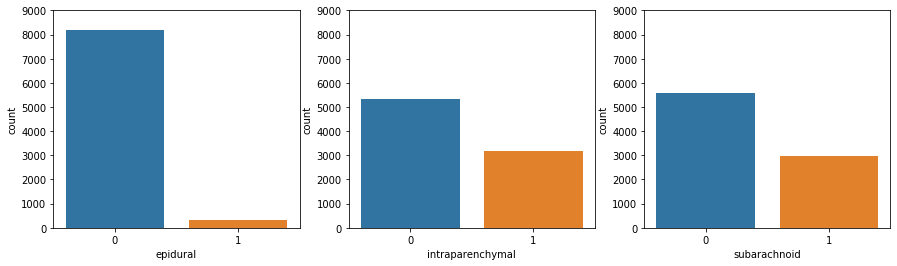

In [68]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.countplot(x='epidural', data=train_info)
plt.yticks(np.arange(0, 10000, 1000))
plt.subplot(1, 3, 2)
sns.countplot(x='intraparenchymal', data=train_info)
plt.yticks(np.arange(0, 10000, 1000))
plt.subplot(1, 3, 3)
sns.countplot(x='subarachnoid', data=train_info)
plt.yticks(np.arange(0, 10000, 1000))
plt.show()

- For each type of ICH, there are more imgs that are "negative" to that class.
- "epidural" has relatively smaller number of "positive" cases.
- __Data Augmentation__ may be needed to make a more balanced traning set.

In [69]:
# total type of ICHs in a sample
train_info['total_types'] = train_info['epidural'] + train_info['intraparenchymal'] + train_info['subarachnoid']

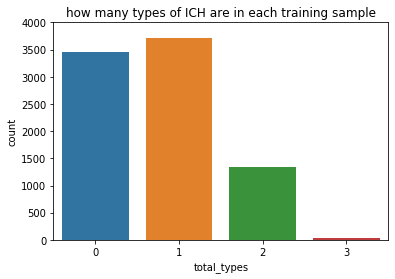

In [70]:
sns.countplot(x='total_types', data=train_info)
plt.title('how many types of ICH are in each training sample')
plt.yticks(np.arange(0, 4500, 500))
plt.show()

- Most imgs in the training set has either 0 or 1 type of ICH.
- Rarely imgs have all three types of ICH, due to less cases of "epidural".

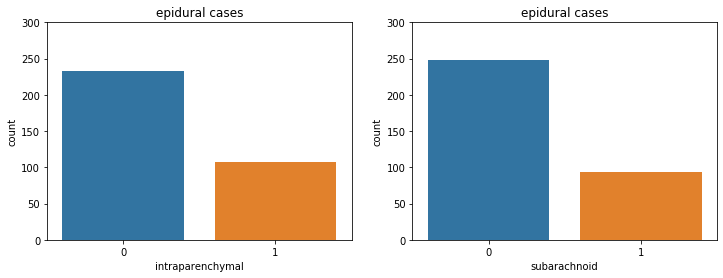

In [71]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.countplot(x='intraparenchymal', data=train_info[train_info['epidural']==1])
plt.yticks(np.arange(0, 350, 50))
plt.title('epidural cases')
plt.subplot(1, 2, 2)
sns.countplot(x='subarachnoid', data=train_info[train_info['epidural']==1])
plt.yticks(np.arange(0, 350, 50))
plt.title('epidural cases')
plt.show()

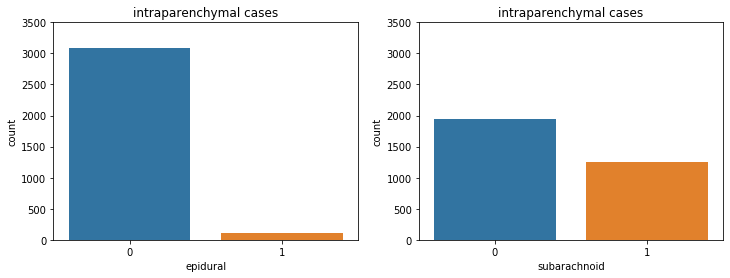

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.countplot(x='epidural', data=train_info[train_info['intraparenchymal']==1])
plt.yticks(np.arange(0, 4000, 500))
plt.title('intraparenchymal cases')
plt.subplot(1, 2, 2)
sns.countplot(x='subarachnoid', data=train_info[train_info['intraparenchymal']==1])
plt.yticks(np.arange(0, 4000, 500))
plt.title('intraparenchymal cases')
plt.show()

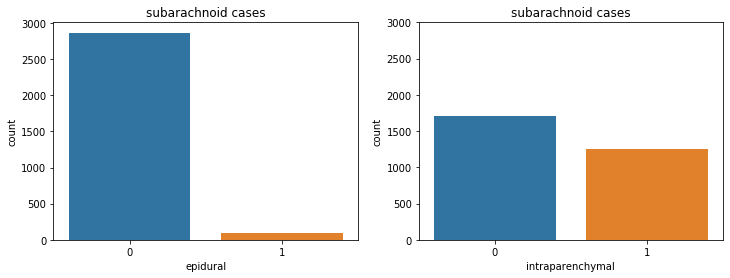

In [73]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.countplot(x='epidural', data=train_info[train_info['subarachnoid']==1])
plt.yticks(np.arange(0, 3500, 500))
plt.title('subarachnoid cases')
plt.subplot(1, 2, 2)
sns.countplot(x='intraparenchymal', data=train_info[train_info['subarachnoid']==1])
plt.yticks(np.arange(0, 3500, 500))
plt.title('subarachnoid cases')
plt.show()

- Generally, having one type of ICH is less likely to have another type.
- Having "intraparenchymal" or "subarachnoid" is very unlikely to have "epidural".
- These observed correlations are __under the assumption that the distribution of the given training set is close to that of the test set or real-world situation__.

## 1.3 Plot some of the images

In [74]:
# function preprocesses an image to tensor
def load_img(path_to_img, max_dim=128):
    max_dim = max_dim
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], dtype=tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape*scale, dtype=tf.int32)
    
    img = tf.image.resize(img, size=new_shape)
    img = img[tf.newaxis, :] # (422, 512, 3) -> (1, 422, 512, 3)
    
    return img 

In [75]:
# function display an image
def show_img(img, title=None):
    if len(img.shape) > 3: # for caces such as (1, 422, 512, 3)
        img = tf.squeeze(img) # Removes dimensions of size 1 from the shape of a tensor
    
    plt.imshow(img)
    if title:
        plt.title(title)

### 1.3.1 images randomly picked

In [76]:
# randomly pick 9 images
image_ids = np.random.choice(train_info['ID'].unique(), 9)

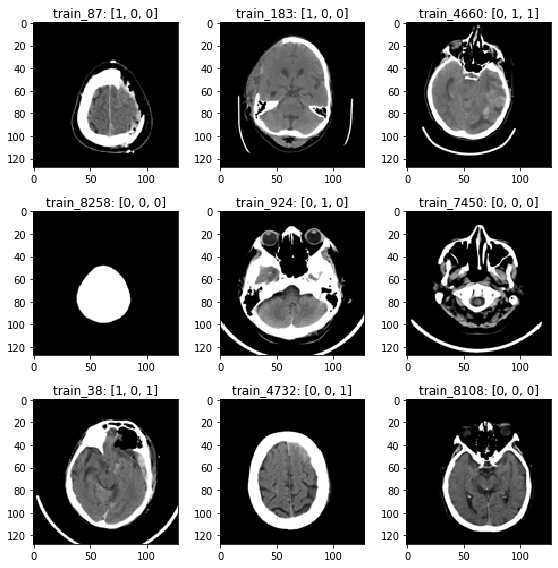

In [77]:
plt.figure(figsize=[8,8])
count=1
for img_id in image_ids:
    path_to_img = os.path.join(train_dir, img_id + '.png')
    img = load_img(path_to_img)
    plt.subplot(3, 3, count)
    show_img(img)
    plt.title(img_id + ': ' + str(train_info[train_info['ID']==img_id].iloc[:, 1:4].values.tolist()[0]))
    plt.tight_layout()
    count+=1

### 1.3.2 images without any ICHs

In [78]:
# images without any type of ICH
image_ids = np.random.choice(train_info[train_info['total_types']==0]['ID'].unique(), 9)

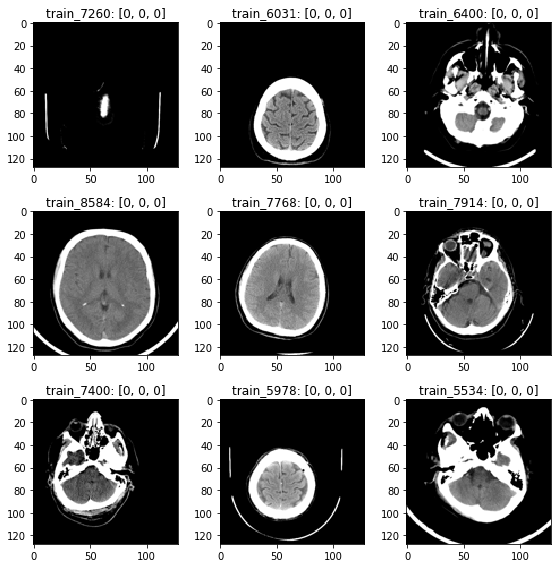

In [79]:
plt.figure(figsize=[8,8])
count=1
for img_id in image_ids:
    path_to_img = os.path.join(train_dir, img_id + '.png')
    img = load_img(path_to_img)
    plt.subplot(3, 3, count)
    show_img(img)
    plt.title(img_id + ': ' + str(train_info[train_info['ID']==img_id].iloc[:, 1:4].values.tolist()[0]))
    plt.tight_layout()
    count+=1

- It looks like some of the images labeled with no any ICHs are when the CT slides do not represent the main part of the brain.

### 1.3.3 images labeled as "epidural"

In [80]:
# images labeled as "epidural"
image_ids = np.random.choice(train_info[train_info['epidural']==1]['ID'].unique(), 9)

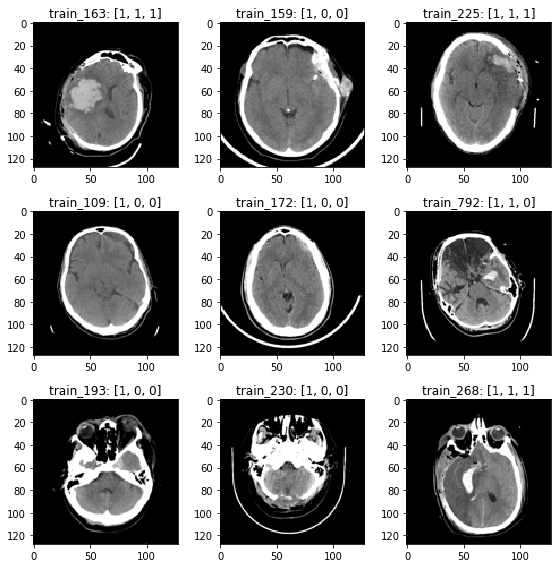

In [81]:
plt.figure(figsize=[8,8])
count=1
for img_id in image_ids:
    path_to_img = os.path.join(train_dir, img_id + '.png')
    img = load_img(path_to_img)
    plt.subplot(3, 3, count)
    show_img(img)
    plt.title(img_id + ': ' + str(train_info[train_info['ID']==img_id].iloc[:, 1:4].values.tolist()[0]))
    plt.tight_layout()
    count+=1

### 1.3.4 images labeled as "intraparenchymal"

In [82]:
# images labeled as "intraparenchymal"
image_ids = np.random.choice(train_info[train_info['intraparenchymal']==1]['ID'].unique(), 9)

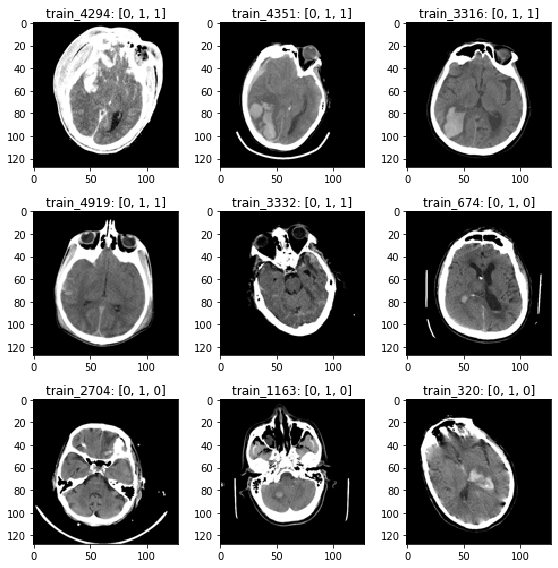

In [83]:
plt.figure(figsize=[8,8])
count=1
for img_id in image_ids:
    path_to_img = os.path.join(train_dir, img_id + '.png')
    img = load_img(path_to_img)
    plt.subplot(3, 3, count)
    show_img(img)
    plt.title(img_id + ': ' + str(train_info[train_info['ID']==img_id].iloc[:, 1:4].values.tolist()[0]))
    plt.tight_layout()
    count+=1

### 1.3.5 images labeled as "subarachnoid"

In [84]:
# images labeled as "subarachnoid"
image_ids = np.random.choice(train_info[train_info['subarachnoid']==1]['ID'].unique(), 9)

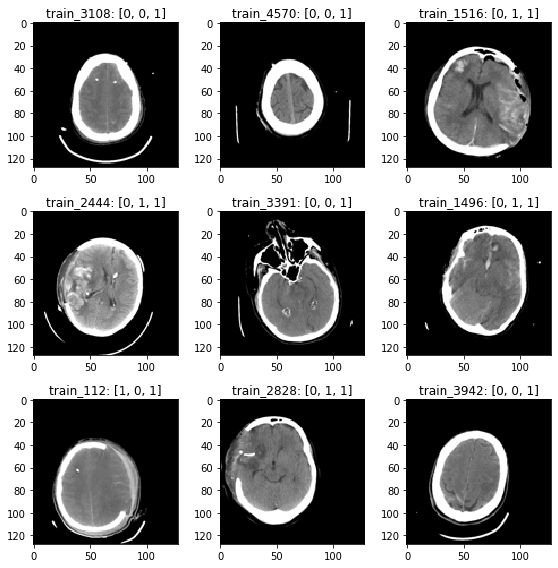

In [85]:
plt.figure(figsize=[8,8])
count=1
for img_id in image_ids:
    path_to_img = os.path.join(train_dir, img_id + '.png')
    img = load_img(path_to_img)
    plt.subplot(3, 3, count)
    show_img(img)
    plt.title(img_id + ': ' + str(train_info[train_info['ID']==img_id].iloc[:, 1:4].values.tolist()[0]))
    plt.tight_layout()
    count+=1

# Part 2: Training

- Part 2 was mainly done using Colab.
- Please check the second notebook for this part.

# Part 3: Model Visualization

## 3.1 Import trained model

In [86]:
# F beta score way2: calculate tp fp fn for each label in the valid set.
# function to calculate F beta score
# "example based" for multi-label classification
# example: y_pred: (None, 3)
def fbeta_score(y_true, y_pred, beta=2):
  y_pred = keras.backend.clip(y_pred, 0, 1) # should be between 0 and 1 if using "sigmoid"
  tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true*y_pred, 0, 1))) # Ture Positive
  fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred-y_true, 0, 1))) # False Positive
  fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true-y_pred, 0, 1))) # False Negative
  p = tp / (tp + fp + keras.backend.epsilon()) # Precision
  r = tp / (tp + fn + keras.backend.epsilon()) # Recall
  bb = beta**2
  fbeta_score = (1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon())
  return fbeta_score

In [87]:
# load the trained model
model_2 = keras.models.load_model('model_2.h5', custom_objects={'fbeta_score':fbeta_score})

In [88]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)       

## 3.2 CAM function

In [89]:
label_name_to_index = {'epidural':0, 'intraparenchymal':1, 'subarachnoid':2}
label_index_to_name = {0:'epidural', 1:'intraparenchymal', 2:'subarachnoid'}

In [93]:
# function outputs original image, heatmap, and merged image
def CAM(model=model_2, layer_name='conv2d_11', image_id='train_216', label_name='epidural', alpha=0.8):
    path_to_img = os.path.join(train_dir, image_id + '.png')
    img = load_img(path_to_img) # -> tensor (1, 128, 128, 3)
    label_index = label_name_to_index[label_name]
    
    gradModel = keras.models.Model(inputs=[model.inputs],
                                   outputs=[model.get_layer(layer_name).output, model.output])
    # get the gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(img, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        prediction = predictions[:, label_index]
    grads = tape.gradient(prediction, convOutputs) # (1, 32, 32, 128)
    # get the weights
    castConvOutputs = tf.cast(convOutputs>0, "float32") # (1, 32, 32, 128), 0 if <0, 1 if >0
    castGrads = tf.cast(grads>0, "float32") # (1, 32, 32, 128), 0 if <0, 1 if >0
    # remain positions with both positive activation and grad, 0 out the others:
    guidedGrads = castConvOutputs * castGrads * grads # (1, 32, 32, 128)
    convOutputs = convOutputs[0] # -> (32, 32, 128)
    guidedGrads = guidedGrads[0] # -> (32, 32, 128)
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1)) # (128)
    # heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=2)
    heatmap = cv2.resize(heatmap.numpy(), (128, 128))
    # rescale heatmap to between (0,1)
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + 1e-7
    heatmap = 1.0 - (numer / denom)
    # back to 255
    heatmap = (heatmap * 255.0).astype("uint8")
    # output original image, heatmap, merged image
    Heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_cv2 = cv2.imread(path_to_img)
    img_merged = cv2.addWeighted(img_cv2, alpha, Heatmap, 1-alpha, 0)
    
    return (img_cv2, Heatmap, img_merged)

In [94]:
# function to help display the information of a given image
def display(image_id='train_216', label_name='epidural'):
    path_to_img = os.path.join(train_dir, image_id + '.png')
    img = load_img(path_to_img)
    
    label_true = train_info[train_info['ID']==image_id].iloc[:, 1:4].values.tolist()[0]
    label_prob = list(model_2.predict(img)[0])
    label_pred = list(map(int,model_2.predict(img)[0].round()))
    
    IMGs = CAM(image_id=image_id, label_name=label_name)
    image = IMGs[0]
    heatmap = IMGs[1]
    cam = IMGs[2]
    
    return {'label_true':label_true, 'label_prob':label_prob, 'label_pred':label_pred,
           'image':image, 'heatmap':heatmap, 'CAM':cam}

## 3.3 Apply CAM

- I manually picked some typical cases to show the application of CAM.

### 3.3.1 an "Epidural" case

In [95]:
disp = display(image_id='train_216', label_name='epidural')

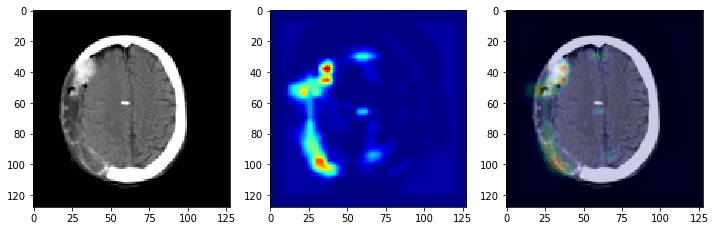

Image_id: train_216
True labels:  Epidural:1  Intraparenchymal:0  Subarachnoid:0
Predicted probs:  0.98224974 0.3963642 0.043372862
Predicted labels:  1 0 0


In [96]:
plt.figure(figsize=[12,12])
plt.subplot(1, 3, 1)
show_img(disp['image'])
plt.subplot(1, 3, 2)
show_img(disp['heatmap'])
plt.subplot(1, 3, 3)
show_img(disp['CAM'])
plt.show()
print ('Image_id: train_216')
print ('True labels: ', 'Epidural:'+ str(disp['label_true'][0]), ' Intraparenchymal:'+ str(disp['label_true'][1]), ' Subarachnoid:'+ str(disp['label_true'][2]))
print ('Predicted probs: ', str(disp['label_prob'][0]), str(disp['label_prob'][1]), str(disp['label_prob'][2]))
print ('Predicted labels: ', str(disp['label_pred'][0]), str(disp['label_pred'][1]), str(disp['label_pred'][2]))

### 3.3.2 an "Intraparenchymal" case

In [105]:
disp = display(image_id='train_320', label_name='intraparenchymal')

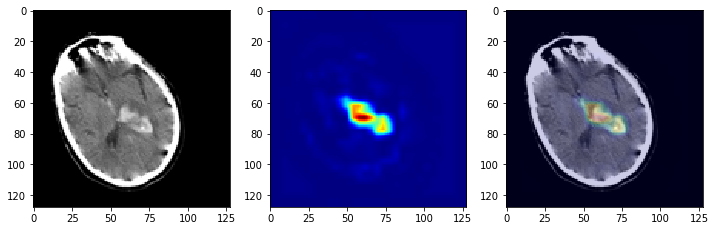

Image_id: train_320
True labels:  Epidural:0  Intraparenchymal:1  Subarachnoid:0
Predicted probs:  8.880147e-05 0.9894252 0.27148357
Predicted labels:  0 1 0


In [107]:
plt.figure(figsize=[12,12])
plt.subplot(1, 3, 1)
show_img(disp['image'])
plt.subplot(1, 3, 2)
show_img(disp['heatmap'])
plt.subplot(1, 3, 3)
show_img(disp['CAM'])
plt.show()
print ('Image_id: train_320')
print ('True labels: ', 'Epidural:'+ str(disp['label_true'][0]), ' Intraparenchymal:'+ str(disp['label_true'][1]), ' Subarachnoid:'+ str(disp['label_true'][2]))
print ('Predicted probs: ', str(disp['label_prob'][0]), str(disp['label_prob'][1]), str(disp['label_prob'][2]))
print ('Predicted labels: ', str(disp['label_pred'][0]), str(disp['label_pred'][1]), str(disp['label_pred'][2]))

### 3.3.3 a "Subarachnoid" case

In [110]:
disp = display(image_id='train_3108', label_name='subarachnoid')

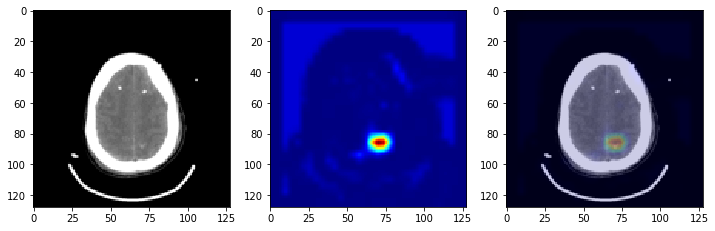

Image_id: train_3108
True labels:  Epidural:0  Intraparenchymal:0  Subarachnoid:1
Predicted probs:  0.19099826 0.37263185 0.6001241
Predicted labels:  0 0 1


In [112]:
plt.figure(figsize=[12,12])
plt.subplot(1, 3, 1)
show_img(disp['image'])
plt.subplot(1, 3, 2)
show_img(disp['heatmap'])
plt.subplot(1, 3, 3)
show_img(disp['CAM'])
plt.show()
print ('Image_id: train_3108')
print ('True labels: ', 'Epidural:'+ str(disp['label_true'][0]), ' Intraparenchymal:'+ str(disp['label_true'][1]), ' Subarachnoid:'+ str(disp['label_true'][2]))
print ('Predicted probs: ', str(disp['label_prob'][0]), str(disp['label_prob'][1]), str(disp['label_prob'][2]))
print ('Predicted labels: ', str(disp['label_pred'][0]), str(disp['label_pred'][1]), str(disp['label_pred'][2]))

### 3.3.4 case with all three types of ICH

In [129]:
disp = display(image_id='train_403', label_name='epidural')
disp2 = display(image_id='train_403', label_name='intraparenchymal')
disp3 = display(image_id='train_403', label_name='subarachnoid')

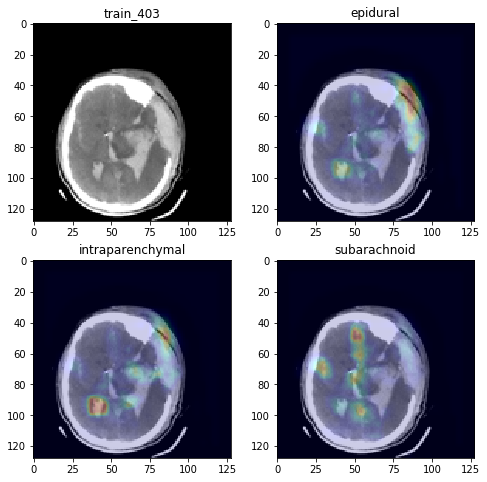

Image_id: train_403
True labels:  Epidural:1  Intraparenchymal:1  Subarachnoid:1
Predicted probs:  0.59538233 0.6799863 0.7434743
Predicted labels:  1 1 1


In [131]:
plt.figure(figsize=[8,8])
plt.subplot(2, 2, 1)
show_img(disp['image'])
plt.title('train_403')
plt.subplot(2, 2, 2)
show_img(disp['CAM'])
plt.title('epidural')
plt.subplot(2, 2, 3)
show_img(disp2['CAM'])
plt.title('intraparenchymal')
plt.subplot(2, 2, 4)
show_img(disp3['CAM'])
plt.title('subarachnoid')
plt.show()
print ('Image_id: train_403')
print ('True labels: ', 'Epidural:'+ str(disp['label_true'][0]), ' Intraparenchymal:'+ str(disp['label_true'][1]), ' Subarachnoid:'+ str(disp['label_true'][2]))
print ('Predicted probs: ', str(disp['label_prob'][0]), str(disp['label_prob'][1]), str(disp['label_prob'][2]))
print ('Predicted labels: ', str(disp['label_pred'][0]), str(disp['label_pred'][1]), str(disp['label_pred'][2]))

- The model may be able to identify multiple labels (ICH types) for a single image on different regions of pixels.

# References

- Coursera specialization: Deep Learning
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Geron
- [Multi-Label Classification of Satellite Photos of the Amazon Rainforest](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/)
- [Visualizing what convnets learn](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb)
- [Grad-CAM: Visualize class activation maps with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/)